## Udacity Data Science Nanodegree: Write a blog project

This notebook contains the workings for the Write a blog project



## Project Overview

I have decided to use the publically available Airbnb data for London. This is quite a large dataset, so I have focused on the location metrics for this project.

## Project Aim
To better understand the geographic dynamics of the Airbnb data by answering the following questions:
#### Question 1 - What is the geographic distribution of Airbnb properties in London?
#### Question 2 - How far are properties from the centre of London?
#### Question 3 - How does price differ with distance from the Centre of London?
#### Question 4 - How does availability differ with distance from the Centre of London?
#### Question 5 - How do amenities change with distance from the Centre of London?


### 1 - Imports and setup


In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


### 2 - Open the data

The downloaded file from Airbnb is 150Mb and is too large for github. In the commented out steps below I have opened the large file, restricted the data to the columns I want to use and saved the cut down csv. 

The smaller file will be uploaded to github.

In [2]:
# open the data and have a look
#df_listings_all = pd.read_csv('data/detailed_listings.csv')

In [3]:
# There is too much data for this project, so cut down the data to just the columns that we want to look at
#df_listings = df_listings_all[['id','neighbourhood_cleansed','property_type','room_type','amenities','price',
#                               'availability_30', 'availability_60', 'availability_90', 'minimum_nights',
#                               'reviews_per_month', 'latitude', 'longitude']].copy()

In [4]:
# save the smaller set of data for this project
#df_listings.to_csv('data/smaller_listings.csv')

In [5]:
# open the smaller listings file (now 30Mb)
df_listings = pd.read_csv('data/smaller_listings.csv')

### 3 - Initial look at the data structure

In [6]:
# Useful functions

def data_structure(df):
    """
    Simple function to show basic information about a dataset
    input: df: a dataframe
    output: none
    """

    # calculate basic info
    ncols = df.shape[1]
    nrows = df.shape[0]
    ncells = ncols * nrows
    nnulls = df.isnull().sum().sum()
    nvalues = df.notnull().sum().sum()
    
    # print output
    print("\n" + "=" * 50)
    print(">> Columns: {:,}".format(ncols))
    print(">> Rows   : {:,}".format(nrows))
    print(">> Cells  : {:,}".format(ncells))
    print(">> Nulls  : {:,} ({:.1%})".format(nnulls, (nnulls / ncells)))
    print(">> Values : {:,} ({:.1%})".format(nvalues, (nvalues / ncells)))
    print("=" * 50)

    
def column_names_types(df):
    """
    Simple function to show basic information about columns in a dataframe
    input: df: a dataframe
    output: none
    """
    # print out data type and column name for each column in dataframe
    print("=" * 50)
    print("{:<10}: {}".format("DATA TYPE", "COLUMN NAME"))
    for col in df.columns:
        print("{:<10}: {}".format(str(df[col].dtype), col))
    print("=" * 50)

    
def samplerows(df, num_rows=5):
    """
    Simple function to show first few rows in a dataframe
    input: 
    df: a dataframe
    num_rows: number of rows to show
    output: none
    """
    #set the view options
    pd.set_option('display.max_columns', df.shape[1])
    
    #print sample of dataframe
    print("=" * 50)
    print(">> Showing a sample of {} rows:".format(num_rows))
    print("=" * 50)
    print(df.sample(num_rows))
    print("=" * 50)

    #set the view options back to normal
    pd.reset_option('display.max_columns', silent=True)


In [7]:
df_listings.head()

,Unnamed: 0,id,neighbourhood_cleansed,property_type,room_type,amenities,price,availability_30,availability_60,availability_90,minimum_nights,reviews_per_month,latitude,longitude
0,0,13913,Islington,Private room in rental unit,Private room,"[""Hot water"", ""Heating"", ""Coffee maker"", ""Buil...",$65.00,26,56,86,1,0.16,51.56861,-0.11270
1,1,15400,Kensington and Chelsea,Entire rental unit,Entire home/apt,"[""Hot water"", ""Heating"", ""Coffee maker"", ""TV w...",$75.00,0,0,0,3,0.61,51.48780,-0.16813
2,2,17402,Westminster,Entire rental unit,Entire home/apt,"[""Hot water"", ""Heating"", ""Coffee maker"", ""Iron...",$265.00,4,34,60,4,0.33,51.52195,-0.14094
3,3,17506,Hammersmith and Fulham,Private room in townhouse,Private room,"[""Shampoo"", ""Carbon monoxide alarm"", ""Hot wate...",$150.00,29,59,89,3,NaN,51.47935,-0.19743
4,4,25123,Barnet,Private room in residential home,Private room,"[""Shampoo"", ""Washer"", ""Heating"", ""Coffee maker...",$29.00,0,0,0,10,0.91,51.57438,-0.21081


In [8]:
data_structure(df_listings)


>> Columns: 14
>> Rows   : 66,641
>> Cells  : 932,974
>> Nulls  : 18,559 (2.0%)
>> Values : 914,415 (98.0%)


In [9]:
# look at the column names and datatypes
column_names_types(df_listings)

DATA TYPE : COLUMN NAME
int64     : Unnamed: 0
int64     : id
object    : neighbourhood_cleansed
object    : property_type
object    : room_type
object    : amenities
object    : price
int64     : availability_30
int64     : availability_60
int64     : availability_90
int64     : minimum_nights
float64   : reviews_per_month
float64   : latitude
float64   : longitude


### 4 - Data Cleaning

In [10]:
# Convert price from text in format "$x,xxx.xx" into a float
df_listings['price'] = df_listings['price'].apply(lambda x: x.replace('$','')).\
    apply(lambda x: x.replace(',','')).astype(np.float64)

In [11]:
# Remove outliers for price to make the data more comparable 
# Hypothesis that there will be a few very expensive properties 
# on airbnb that for purposes of this analysis we are not interested in

# how many prices are above $500
print('Properties above $500: ', df_listings[df_listings['price']>500]['id'].count())



Properties above $500:  2313


In [12]:
# remove any properties that cost more than $500 per night
df_listings = df_listings[df_listings['price']<=500]

In [13]:
# Hypothesis - properties with no availability in next 90 days are not typical airbnb properties, so remove
# how many properties have no availability in next 90 days
print('Properties with no availability in next 90 days: ', df_listings[df_listings['availability_90']==0]['id'].count())

Properties with no availability in next 90 days:  34238


In [14]:
# remove any properties that have no availability for next 90 days
df_listings = df_listings[df_listings['availability_90']!=0]

In [15]:
# Hypothesis properties with more than 7 days booking requirement are not typical airbnb properties
print('Properties with more than 7 days booking requirement: ', df_listings[df_listings['minimum_nights']>7]['id'].count())

Properties with more than 7 days booking requirement:  3096


In [16]:
# remove any properties that have a requirement for more than 7 days booking
df_listings = df_listings[df_listings['minimum_nights']<=7]

In [17]:
# how many properties remain
print('Properties remaining in data: ', df_listings['id'].count())

Properties remaining in data:  26994


## Question 1 - What is the geographic distribution of Airbnb properties in London?

Acknowledgements: 

How to use geopandas to plot on a map - https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

London Borough shape file - https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london

How to calculate distance from latitude and longitude - https://community.esri.com/t5/coordinate-reference-systems-blog/distance-on-a-sphere-the-haversine-formula/ba-p/902128



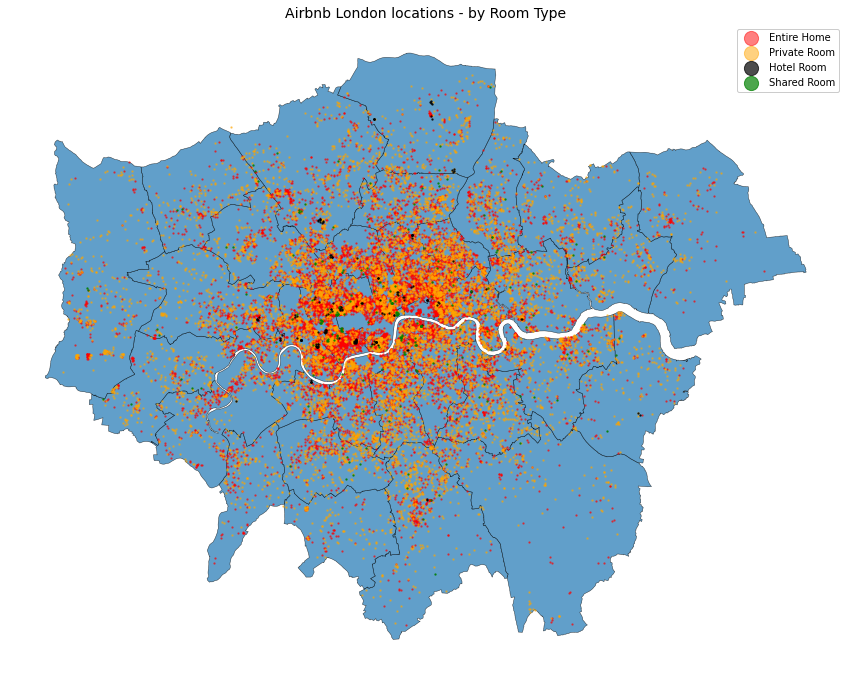

In [18]:
# read in the London Borough shape file
london_map = gpd.read_file('map/London_Borough_Excluding_MHW.shp')
london_map = london_map.to_crs("epsg:4326")

# create a geo dataframe for the airbnb listings
geometry = [Point(xy) for xy in zip(df_listings['longitude'], df_listings['latitude'])]
crs = "epsg:4326"
geo_df = gpd.GeoDataFrame(df_listings, crs = crs, geometry = geometry)

# plot the results
fig,ax = plt.subplots(figsize = (15,15))
london_map.plot(ax = ax, alpha=0.7, linewidth=.5, edgecolor='black')

geo_df[geo_df['room_type']=='Entire home/apt'].plot(ax = ax, markersize = 2, alpha = 0.5, color = 'red' ,marker = 'o', label = 'Entire Home')
geo_df[geo_df['room_type']=='Private room'].plot(ax = ax, markersize = 2, alpha = 0.5, color = 'orange' ,marker = 'o', label = 'Private Room')
geo_df[geo_df['room_type']=='Hotel room'].plot(ax = ax, markersize = 2, alpha = 0.7, color = 'black' ,marker = 'o', label = 'Hotel Room')
geo_df[geo_df['room_type']=='Shared room'].plot(ax = ax, markersize = 2, alpha = 0.7, color = 'green' ,marker = 'o', label = 'Shared Room')
plt.axis('off')
plt.legend(prop={'size': 10}, markerscale = 10, framealpha = 1)
plt.title("Airbnb London locations - by Room Type", size = 14)
plt.savefig("1_Airbnb_locations.png", bbox_inches = 'tight')
plt.show()

## Question 2 - How far are properties from the centre of London?

In [19]:
def haversine(coord1, coord2):
    """
    Function to calculate distance from latitude and longitude co-ordinates
    inputs: coord1, coord2: coordinates for the two points to calculate distance
    output: distance: distance in km
    """
    import math
    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    meters = round(meters)
    km = round(km, 3)
    #print(f"Distance: {meters} m")
    #print(f"Distance: {km} km")
    
    return km

#### The centre of London is taken as the Charles I statue south of Trafalgar Square.
https://en.wikipedia.org/wiki/Central_London
#### The longitude and latitude of that statue are 51.50744,-0.12733 (as per Google Maps)

In [20]:
# Set the centre of London as the coordinates of 
centre_of_london = (51.50744,-0.12733)

# Add a column for distance from centre (in km)
geo_df['dist_from_centre'] =  geo_df.apply(lambda row: haversine(centre_of_london, (row.latitude, row.longitude)), axis = 1)

# reset indices
geo_df.reset_index(drop=True, inplace=True)

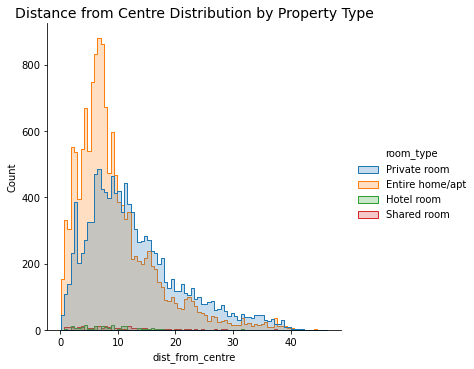

In [21]:
# Plot the distribution of 'distance from centre of London'
sns.displot(geo_df, x='dist_from_centre', element = 'step', hue = 'room_type')
plt.title('Distance from Centre Distribution by Property Type', size = 14)
plt.savefig("2_distance_from_centre_distribution.png", bbox_inches = 'tight')
plt.show()

## Question 3 - How does price differ with distance from the Centre of London?

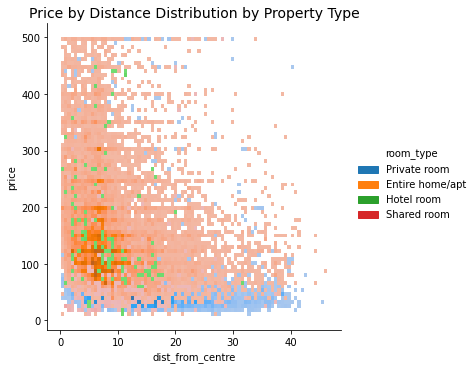

In [22]:
# Plot price vs distance
sns.displot(geo_df, x='dist_from_centre', y = 'price', hue = 'room_type')
plt.title('Price by Distance Distribution by Property Type', size = 14)
plt.savefig("3_price_by_distance_distribution.png", bbox_inches = 'tight')
plt.show()

## Question 4 - How does availability differ with distance from the Centre of London?

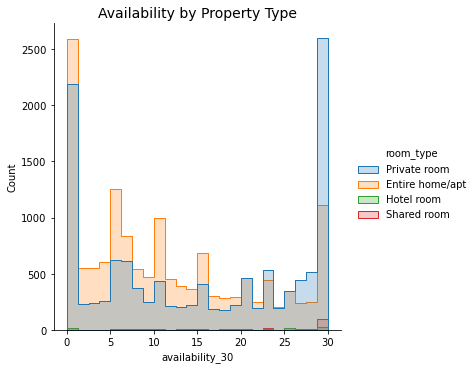

In [23]:
# Plot distribution of 'availability in next 30 days'
sns.displot(geo_df, x='availability_30', element = 'step', hue = 'room_type')
plt.title('Availability by Property Type', size = 14)
plt.savefig("4_availability_distribution.png", bbox_inches = 'tight')
plt.show()

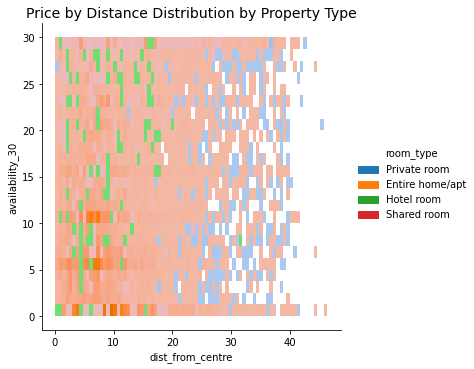

In [24]:
# Plot availability vs distance
sns.displot(geo_df, x='dist_from_centre', y = 'availability_30', hue = 'room_type')
plt.title('Price by Distance Distribution by Property Type', size = 14)
plt.savefig("4_availability_by_distance_distribution.png", bbox_inches = 'tight')
plt.show()

## Question 5 - How do amenities change with distance from the Centre of London?

In [25]:
# Amenities column contains a list for each property

amenity_list = []
amenity_set = set()

# extract into one long list of amenities
for i in range(len(geo_df)):
    amenity_list.append((geo_df['amenities'][i]).strip('[]').replace('"','').split(','))

# convert into one set
for i in amenity_list:
    for j in i:
        amenity_set.add(j.lstrip(' ').replace('\\','').replace('u2013','').replace('u2019',''))
    
print("how many amenities are there overall?: ", len(amenity_set))
print("first 50 values: \n", list(amenity_set)[0:50])

how many amenities are there overall?:  2308
first 50 values: 
 ['', 'Fiils - Natural Chemical Free - Refillable Bottles conditioner', 'Bose bluetooth speaker sound system', 'Baylis & Harding', 'Lacura -Uplifting shower gel  body soap', 'Common one conditioner', 'Keypad', '38 TV with standard cable', 'Sea Kelp body soap', 'Amazon Alexa Bluetooth sound system', 'normal shampoo shampoo', 'Miele  refrigerator', 'Caroline Henry  body soap', 'jbl in bulbs Bluetooth sound system', 'Cien shampoo', 'Natural soap body soap', 'induction stove', '58 HDTV', 'Fast wifi  219 Mbps', 'dove or other brands body soap', 'Fast wifi  110 Mbps', 'Russell Hobbs under the counter fridge and freezer  refrigerator', 'jbl speakers in bulbs Bluetooth sound system', 'Kinsey Apothecary conditioner', 'Kinsey Apothecary shampoo', 'Any conditioner', 'Free dryer  In unit', 'Bose  Bluetooth sound system', 'Wifi  39 Mbps', 'Cole & Lewis body soap', 'Faith in Nature - Wild Rose (100% nature fragrance', 'Herbal Essences  c

### Observation: 
Amenities is a varied set of items - and many do not seem like amenities...
It still might be interesting to look at the count of amenities and see whether any trends can be seen 

In [26]:
# Create a new field "number_of_amenities" in the dataframe
geo_df['number_of_amenities'] = geo_df.apply(lambda row: len(list((row.amenities).strip('[]').replace('"','').split(','))), axis = 1)

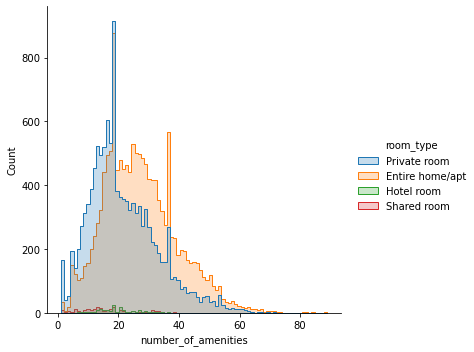

In [27]:
# Plot distribution of 'number of amenities'
sns.displot(geo_df, x='number_of_amenities', element = 'step', hue = 'room_type')

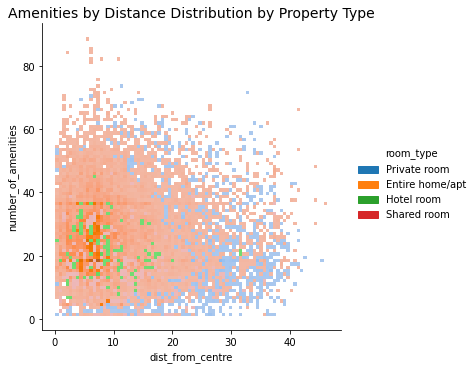

In [28]:
# Plot number of amenities vs distance
sns.displot(geo_df, x='dist_from_centre', y = 'number_of_amenities', hue = 'room_type')
plt.title('Amenities by Distance Distribution by Property Type', size = 14)
plt.savefig("5_amenities_by_distance_distribution.png", bbox_inches = 'tight')
plt.show()